In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from datetime import timedelta
from datetime import datetime

# 모든 열이 출력되도록 설정
pd.set_option('display.max_columns', None)

[데이터셋]
1. 고가 프차 카페 개수 **cafe_french_high.csv**
2. 저가 프차 카페 개수 **cafe_french_low.csv**  
3. 중가 프차 카페 개수 **cafe_french_mid.csv** 
4. 개인 카페 개수 **cafe_nonfrench.csv** 
5. 스타벅스 개수 **cafe_starbucks.csv** 
6. 음식점 개수 **food_.csv**
7. 파생변수 만든 최종데이터셋 
- 카페 개업시점 이전 달 기준 영업중인 반경 이내 카페/음식점 개수
- [반경 설정]
    - 500m (도보 8-10분)
    - 250m (도보 3-5분)

[반경 설정]
1. 500m (도보 8-10분)
2. 250m (도보 3-5분)

# 0. 데이터셋 불러오기

In [37]:
cafe_final = pd.read_csv("./cafedata_1101.csv")

In [38]:
data = cafe_final.copy()

In [39]:
cafe_final.head()

,업소명,행정동명,소재지도로명,영업자시작일,폐업일자,총면적,카페명,복층여부,x,y,폐업여부,카페유형,총영업일,월,계절,xy_combined
0,커피앤모바일,장위제1동,서울특별시 성북구 장월로 174 (장위동),2010-01-04,2010-04-02,17.36,커피앤모바일,0,127.053810,37.619456,1,개인 카페,88,1,겨울,"(127.0538105, 37.6194558)"
1,커피사업지원센타,원효로제2동,"서울특별시 용산구 효창원로12길 37, (원효로4가,(지상1층))",2010-01-04,NaN,89.10,커피사업지원센타,0,126.952872,37.533354,0,개인 카페,5015,1,겨울,"(126.9528724, 37.533354)"
2,할리스커피(동덕여대점),월곡제1동,"서울특별시 성북구 화랑로11길 23-6, (하월곡동,지하1층~지상1층(지하30평,그...",2010-01-04,NaN,390.88,할리스,0,127.041656,37.603577,0,고가 프랜차이즈,5015,1,겨울,"(127.0416558, 37.6035772)"
3,카페모넬린,화양동,서울특별시 광진구 광나루로20길 36-3 (화양동),2010-01-04,2011-12-05,53.30,카페모넬린,0,127.073852,37.545336,1,개인 카페,700,1,겨울,"(127.0738519, 37.5453363)"
4,(주)도르체비타,도곡2동,"서울특별시 강남구 언주로30길 56 (도곡동, 타워팰리스)",2010-01-05,2010-05-18,6.60,(주)도르체비타,0,127.054666,37.488555,1,개인 카페,133,1,겨울,"(127.0546662, 37.4885555)"


In [40]:
cafe_final.info() #47749행

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47749 entries, 0 to 47748
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   업소명          47749 non-null  object 
 1   행정동명         47749 non-null  object 
 2   소재지도로명       47749 non-null  object 
 3   영업자시작일       47749 non-null  object 
 4   폐업일자         19505 non-null  object 
 5   총면적          47749 non-null  float64
 6   카페명          47749 non-null  object 
 7   복층여부         47749 non-null  int64  
 8   x            47749 non-null  float64
 9   y            47749 non-null  float64
 10  폐업여부         47749 non-null  int64  
 11  카페유형         47749 non-null  object 
 12  총영업일         47749 non-null  int64  
 13  월            47749 non-null  int64  
 14  계절           47749 non-null  object 
 15  xy_combined  47749 non-null  object 
dtypes: float64(3), int64(4), object(9)
memory usage: 5.8+ MB


In [41]:
# 날짜타입으로 변환
cafe_final['영업자시작일'] = pd.to_datetime(cafe_final['영업자시작일'])
cafe_final['폐업일자'] = pd.to_datetime(cafe_final['폐업일자'])

In [ ]:
# 변환 확인
cafe_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47749 entries, 0 to 47748
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   업소명          47749 non-null  object        
 1   행정동명         47749 non-null  object        
 2   소재지도로명       47749 non-null  object        
 3   영업자시작일       47749 non-null  datetime64[ns]
 4   폐업일자         19505 non-null  datetime64[ns]
 5   총면적          47749 non-null  float64       
 6   카페명          47749 non-null  object        
 7   복층여부         47749 non-null  int64         
 8   x            47749 non-null  float64       
 9   y            47749 non-null  float64       
 10  폐업여부         47749 non-null  int64         
 11  카페유형         47749 non-null  object        
 12  총영업일         47749 non-null  int64         
 13  월            47749 non-null  int64         
 14  계절           47749 non-null  object        
 15  xy_combined  47749 non-null  object        
dtypes: d

In [42]:
df = cafe_final.copy()

In [ ]:
cafe_fren_high = df[df['카페유형']=='고가 프랜차이즈']
cafe_fren_low = df[df['카페유형']=='저가 프랜차이즈']
cafe_fren_mid = df[df['카페유형']=='중가 프랜차이즈']
cafe_nonfren = df[df['카페유형']=='개인 카페']
cafe_starbucks = df[df['카페명']=='스타벅스']

#cafe_fren_high.to_csv('cafe_fren_high.csv' , index=False, encoding='utf-8-sig')
#cafe_fren_low.to_csv('cafe_fren_low.csv' , index=False, encoding='utf-8-sig')
#cafe_fren_mid.to_csv('cafe_fren_mid.csv' , index=False, encoding='utf-8-sig')
#cafe_nonfren.to_csv('cafe_nonfren.csv' , index=False, encoding='utf-8-sig')
#cafe_starbucks.to_csv('cafe_starbucks.csv' , index=False, encoding='utf-8-sig')

# 1. 상권 파생변수 만들기

In [8]:
# 각 카페에 대해 500m 반경 내 매장 개수 계산 함수 정의

def count_mall_500m(cafe_row, mall_gdf):
    # 카페 영업 시작 전 달 구하기
    target_date = cafe_row['영업자시작일'] - timedelta(days=30)
    
    # 조건에 맞는 스타벅스 필터링 (영업 시작 전 달 기준으로 존재하는 매장)
    nearby_mall = mall_gdf[
        ( mall_gdf['영업자시작일'] <= target_date) &
        ((mall_gdf['폐업일자'].isna()) | (mall_gdf['폐업일자'] > target_date))
    ]
    
    # 카페의 반경 500m 내에 있는 매장 개수 계산
    buffer = cafe_row.geometry.buffer(500)  # 반경 500m의 버퍼 생성
    count = nearby_mall[nearby_mall.geometry.within(buffer)].shape[0]
    return count

In [9]:
# 각 카페에 대해 250m 반경 내 매장 개수 계산 함수 정의

def count_mall_250m(cafe_row, mall_gdf):
    # 카페 영업 시작 전 달 구하기
    target_date = cafe_row['영업자시작일'] - timedelta(days=30)
    
    # 조건에 맞는 스타벅스 필터링 (영업 시작 전 달 기준으로 존재하는 매장)
    nearby_mall = mall_gdf[
        ( mall_gdf['영업자시작일'] <= target_date) &
        ((mall_gdf['폐업일자'].isna()) | (mall_gdf['폐업일자'] > target_date))
    ]
    
    # 카페의 반경 250m 내에 있는 매장 개수 계산
    buffer = cafe_row.geometry.buffer(250)  # 반경 250m의 버퍼 생성
    count = nearby_mall[nearby_mall.geometry.within(buffer)].shape[0]
    return count

In [ ]:
# 메인데이터셋
## GeoDataFrame으로 변환 (위도, 경도)
## 좌표계 변환 (WGS84 -> EPSG:5179)
cafe_gdf = gpd.GeoDataFrame(cafe_final, geometry=gpd.points_from_xy(cafe_final['x'], cafe_final['y']), crs='EPSG:4326')
cafe_gdf = cafe_gdf.to_crs(epsg=5179)

## 1-1. 고가 프차 개수
- cafe_fren_high, cafe_final 

In [44]:
cafe_fren_high.info() # 1697개

<class 'pandas.core.frame.DataFrame'>
Index: 1607 entries, 2 to 47742
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   업소명          1607 non-null   object        
 1   행정동명         1607 non-null   object        
 2   소재지도로명       1607 non-null   object        
 3   영업자시작일       1607 non-null   datetime64[ns]
 4   폐업일자         265 non-null    datetime64[ns]
 5   총면적          1607 non-null   float64       
 6   카페명          1607 non-null   object        
 7   복층여부         1607 non-null   int64         
 8   x            1607 non-null   float64       
 9   y            1607 non-null   float64       
 10  폐업여부         1607 non-null   int64         
 11  카페유형         1607 non-null   object        
 12  총영업일         1607 non-null   int64         
 13  월            1607 non-null   int64         
 14  계절           1607 non-null   object        
 15  xy_combined  1607 non-null   object        
dtypes: datetim

In [45]:
cafe_fren_high.head()

,업소명,행정동명,소재지도로명,영업자시작일,폐업일자,총면적,카페명,복층여부,x,y,폐업여부,카페유형,총영업일,월,계절,xy_combined
2,할리스커피(동덕여대점),월곡제1동,"서울특별시 성북구 화랑로11길 23-6, (하월곡동,지하1층~지상1층(지하30평,그...",2010-01-04,NaT,390.88,할리스,0,127.041656,37.603577,0,고가 프랜차이즈,5015,1,겨울,"(127.0416558, 37.6035772)"
12,투썸플레이스 송파장지역점,문정2동,"서울특별시 송파구 충민로 66, F동 B1029호 (문정동, 가든파이브 라이프)",2010-01-06,NaT,245.46,투썸플레이스,0,127.124962,37.477615,0,고가 프랜차이즈,5013,1,겨울,"(127.1249617, 37.4776148)"
32,파스쿠찌 보라매점,신대방제2동,"서울특별시 동작구 보라매로5가길 7, (신대방동,캐릭터그린빌 1층 108호)",2010-01-15,NaT,69.00,파스쿠찌,0,126.924968,37.491953,0,고가 프랜차이즈,5004,1,겨울,"(126.9249684, 37.4919528)"
66,스타벅스 보라매타운점,신대방제2동,"서울특별시 동작구 보라매로5길 43, (신대방동,보라매삼성쉐르빌 상가 1층 121호)",2010-01-26,2019-02-01,159.73,스타벅스,0,126.923416,37.491478,1,고가 프랜차이즈,3293,1,겨울,"(126.9234164, 37.4914777)"
76,스타벅스 삼성역사거리점,대치2동,"서울특별시 강남구 테헤란로98길 11, (대치동,지상1층)",2010-01-29,2017-11-30,505.54,스타벅스,0,127.062717,37.507631,1,고가 프랜차이즈,2862,1,겨울,"(127.0627169, 37.507631)"


In [ ]:
# 고가프차 데이터셋 
cafe_fren_high_gdf = gpd.GeoDataFrame(cafe_fren_high, geometry=gpd.points_from_xy(cafe_fren_high['x'], cafe_fren_high['y']), crs='EPSG:4326')
cafe_fren_high_gdf = cafe_fren_high_gdf.to_crs(epsg=5179)

### 1) 500m 반경

(array([4.0096e+04, 4.7270e+03, 1.7260e+03, 7.1200e+02, 2.0400e+02,
        8.5000e+01, 4.9000e+01, 7.8000e+01, 5.9000e+01, 1.3000e+01]),
 array([ 0. ,  4.4,  8.8, 13.2, 17.6, 22. , 26.4, 30.8, 35.2, 39.6, 44. ]),
 <BarContainer object of 10 artists>)

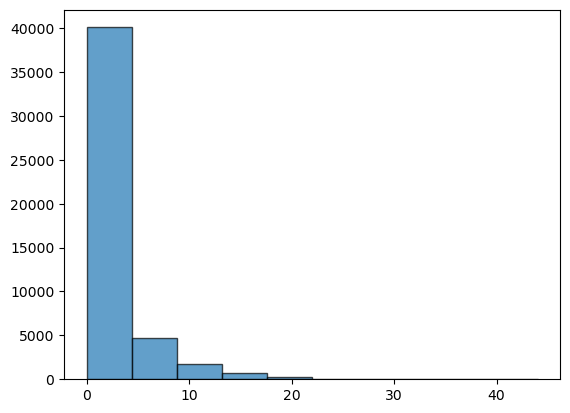

In [ ]:
# 고가프차 개수 파생 변수 추가
cafe_gdf['고가프차 개수_500m'] = cafe_gdf.apply(count_mall_500m, axis=1, mall_gdf=cafe_fren_high_gdf)

# 히스토그램으로 확인
plt.hist(cafe_gdf['고가프차 개수_500m'], bins=10, edgecolor='black', alpha=0.7)

### 2) 250m 반경

(array([3.892e+04, 5.617e+03, 1.747e+03, 8.090e+02, 5.220e+02, 9.100e+01,
        2.200e+01, 1.600e+01, 4.000e+00, 1.000e+00]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <BarContainer object of 10 artists>)

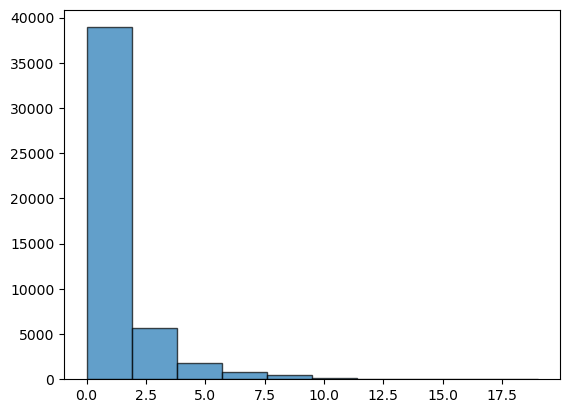

In [ ]:
# 고가프차 개수 파생 변수 추가
cafe_gdf['고가프차 개수_250m'] = cafe_gdf.apply(count_mall_250m, axis=1, mall_gdf=cafe_fren_high_gdf)

# 히스토그램으로 확인
plt.hist(cafe_gdf['고가프차 개수_250m'], bins=10, edgecolor='black', alpha=0.7)

## 1-2. 저가 프차 개수

In [63]:
cafe_fren_low.info() # 1817

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1817 entries, 0 to 1816
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   업소명          1817 non-null   object 
 1   행정동명         1817 non-null   object 
 2   소재지도로명       1817 non-null   object 
 3   영업자시작일       1817 non-null   object 
 4   폐업일자         63 non-null     object 
 5   총면적          1817 non-null   float64
 6   카페명          1817 non-null   object 
 7   복층여부         1817 non-null   int64  
 8   x            1817 non-null   float64
 9   y            1817 non-null   float64
 10  폐업여부         1817 non-null   int64  
 11  카페유형         1817 non-null   object 
 12  총영업일         1817 non-null   int64  
 13  월            1817 non-null   int64  
 14  계절           1817 non-null   object 
 15  xy_combined  1817 non-null   object 
dtypes: float64(3), int64(4), object(9)
memory usage: 227.3+ KB


(array([3.9926e+04, 4.2410e+03, 2.5680e+03, 5.5200e+02, 2.7600e+02,
        1.4500e+02, 2.1000e+01, 1.7000e+01, 1.0000e+00, 2.0000e+00]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <BarContainer object of 10 artists>)

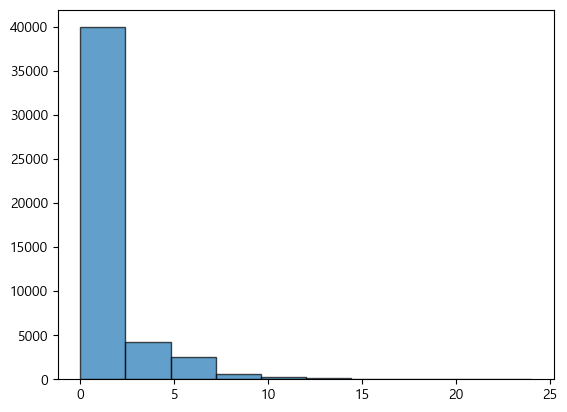

In [ ]:
# 저가프차 데이터셋 
cafe_fren_low_gdf = gpd.GeoDataFrame(cafe_fren_low, geometry=gpd.points_from_xy(cafe_fren_low['x'], cafe_fren_low['y']), crs='EPSG:4326')
cafe_fren_low_gdf = cafe_fren_low_gdf.to_crs(epsg=5179)

# 저가프차 개수 파생 변수 추가
cafe_gdf['저가프차 개수_500m'] = cafe_gdf.apply(count_mall_500m, axis=1, mall_gdf=cafe_fren_low_gdf)

# 히스토그램으로 확인
plt.hist(cafe_gdf['저가프차 개수_500m'], bins=10, edgecolor='black', alpha=0.7)

### 1) 500m

(array([4.0096e+04, 4.7270e+03, 1.7260e+03, 7.1200e+02, 2.0400e+02,
        8.5000e+01, 4.9000e+01, 7.8000e+01, 5.9000e+01, 1.3000e+01]),
 array([ 0. ,  4.4,  8.8, 13.2, 17.6, 22. , 26.4, 30.8, 35.2, 39.6, 44. ]),
 <BarContainer object of 10 artists>)

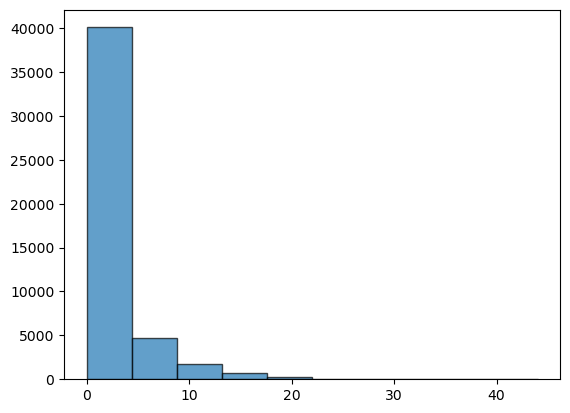

In [56]:
# 저가프차 개수 파생 변수 추가
cafe_gdf['저가프차 개수_500m'] = cafe_gdf.apply(count_mall_500m, axis=1, mall_gdf=cafe_fren_low_gdf)

# 히스토그램으로 확인
plt.hist(cafe_gdf['저가프차 개수_500m'], bins=10, edgecolor='black', alpha=0.7)

### 2) 250m

(array([3.892e+04, 5.617e+03, 1.747e+03, 8.090e+02, 5.220e+02, 9.100e+01,
        2.200e+01, 1.600e+01, 4.000e+00, 1.000e+00]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <BarContainer object of 10 artists>)

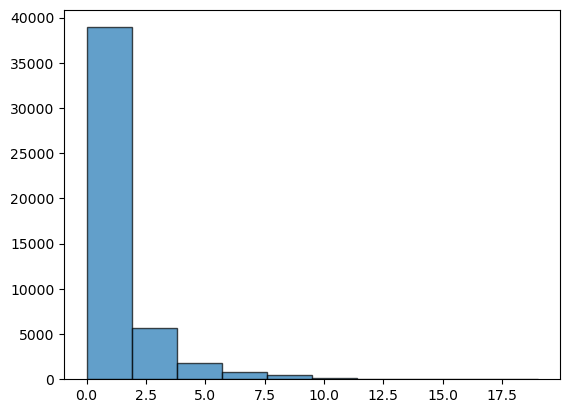

In [59]:
# 저가프차 개수(250) 파생 변수 추가
cafe_gdf['저가프차 개수_250m'] = cafe_gdf.apply(count_mall_250m, axis=1, mall_gdf=cafe_fren_low_gdf)

# 히스토그램으로 확인
plt.hist(cafe_gdf['저가프차 개수_250m'], bins=10, edgecolor='black', alpha=0.7)

## 1-3. 중가 프차 개수

In [60]:
cafe_fren_mid.info() # 1290

<class 'pandas.core.frame.DataFrame'>
Index: 1290 entries, 134 to 47721
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   업소명          1290 non-null   object        
 1   행정동명         1290 non-null   object        
 2   소재지도로명       1290 non-null   object        
 3   영업자시작일       1290 non-null   datetime64[ns]
 4   폐업일자         237 non-null    datetime64[ns]
 5   총면적          1290 non-null   float64       
 6   카페명          1290 non-null   object        
 7   복층여부         1290 non-null   int64         
 8   x            1290 non-null   float64       
 9   y            1290 non-null   float64       
 10  폐업여부         1290 non-null   int64         
 11  카페유형         1290 non-null   object        
 12  총영업일         1290 non-null   int64         
 13  월            1290 non-null   int64         
 14  계절           1290 non-null   object        
 15  xy_combined  1290 non-null   object        
dtypes: datet

In [ ]:
# 중가프차 데이터셋 gdf로로
cafe_fren_mid_gdf = gpd.GeoDataFrame(cafe_fren_mid, geometry=gpd.points_from_xy(cafe_fren_mid['x'], cafe_fren_mid['y']), crs='EPSG:4326')
cafe_fren_mid_gdf = cafe_fren_mid_gdf.to_crs(epsg=5179)

### 1) 500m

(array([2.8454e+04, 8.2460e+03, 7.6910e+03, 1.4620e+03, 1.3210e+03,
        2.5800e+02, 2.3800e+02, 3.6000e+01, 4.0000e+01, 3.0000e+00]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <BarContainer object of 10 artists>)

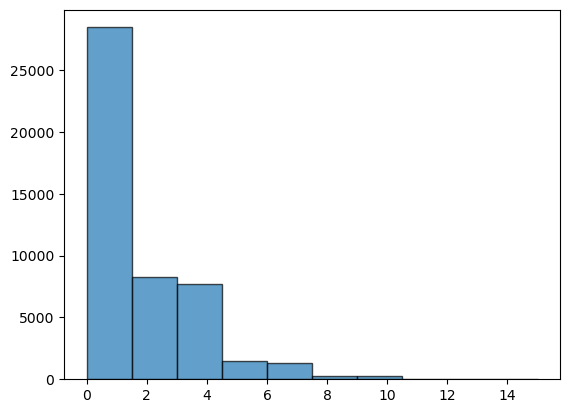

In [62]:
# 중가프차 개수(500) 파생 변수 추가
cafe_gdf['중가프차 개수_500m'] = cafe_gdf.apply(count_mall_500m, axis=1, mall_gdf=cafe_fren_mid_gdf)

# 히스토그램으로 확인
plt.hist(cafe_gdf['중가프차 개수_500m'], bins=10, edgecolor='black', alpha=0.7)

### 2) 250m

(array([3.892e+04, 5.617e+03, 1.747e+03, 8.090e+02, 5.220e+02, 9.100e+01,
        2.200e+01, 1.600e+01, 4.000e+00, 1.000e+00]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <BarContainer object of 10 artists>)

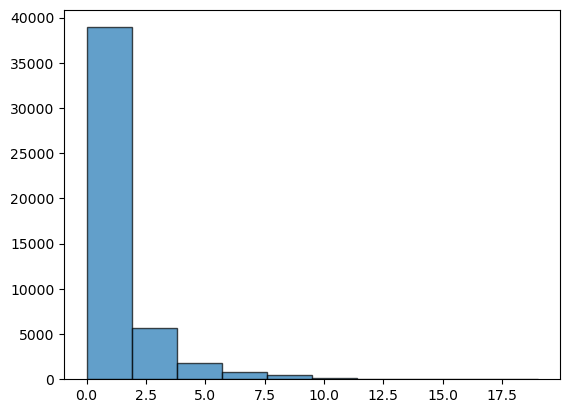

In [63]:
# 중가프차 개수(250) 파생 변수 추가
cafe_gdf['중가프차 개수_250m'] = cafe_gdf.apply(count_mall_250m, axis=1, mall_gdf=cafe_fren_mid_gdf)

# 히스토그램으로 확인
plt.hist(cafe_gdf['저가프차 개수_250m'], bins=10, edgecolor='black', alpha=0.7)

## 1-5. 스타벅스 개수 

In [65]:
cafe_starbucks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 653 entries, 66 to 47708
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   업소명          653 non-null    object        
 1   행정동명         653 non-null    object        
 2   소재지도로명       653 non-null    object        
 3   영업자시작일       653 non-null    datetime64[ns]
 4   폐업일자         31 non-null     datetime64[ns]
 5   총면적          653 non-null    float64       
 6   카페명          653 non-null    object        
 7   복층여부         653 non-null    int64         
 8   x            653 non-null    float64       
 9   y            653 non-null    float64       
 10  폐업여부         653 non-null    int64         
 11  카페유형         653 non-null    object        
 12  총영업일         653 non-null    int64         
 13  월            653 non-null    int64         
 14  계절           653 non-null    object        
 15  xy_combined  653 non-null    object        
dtypes: datetim

In [66]:
# 스타벅스 데이터셋 
cafe_starbucks_gdf = gpd.GeoDataFrame(cafe_starbucks, geometry=gpd.points_from_xy(cafe_starbucks['x'], cafe_starbucks['y']), crs='EPSG:4326')
cafe_starbucks_gdf = cafe_starbucks_gdf.to_crs(epsg=5179)

### 1) 500m

(array([4.243e+04, 2.862e+03, 1.610e+03, 3.910e+02, 1.460e+02, 1.020e+02,
        5.000e+01, 6.200e+01, 8.000e+01, 1.600e+01]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <BarContainer object of 10 artists>)

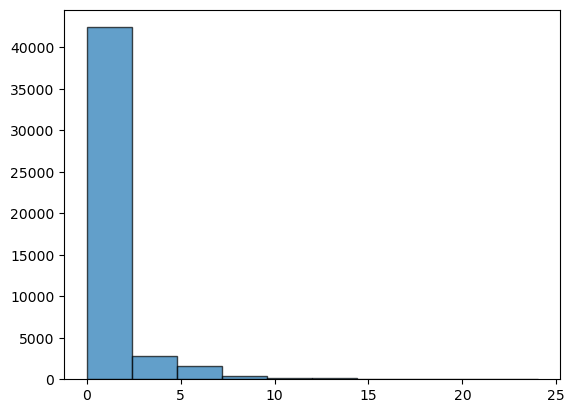

In [67]:
# 중가프차 개수(500) 파생 변수 추가
cafe_gdf['스타벅스 개수_500m'] = cafe_gdf.apply(count_mall_500m, axis=1, mall_gdf=cafe_starbucks_gdf)

# 히스토그램으로 확인
plt.hist(cafe_gdf['스타벅스 개수_500m'], bins=10, edgecolor='black', alpha=0.7)

### 2) 250m

(array([4.4731e+04, 1.5390e+03, 9.6900e+02, 2.8000e+02, 1.0100e+02,
        7.9000e+01, 3.1000e+01, 1.1000e+01, 7.0000e+00, 1.0000e+00]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

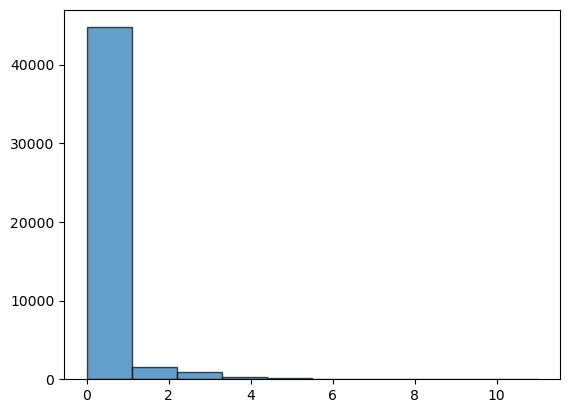

In [68]:
# 스타벅스 개수(250) 파생 변수 추가
cafe_gdf['스타벅스 개수_250m'] = cafe_gdf.apply(count_mall_250m, axis=1, mall_gdf=cafe_starbucks_gdf)

# 히스토그램으로 확인
plt.hist(cafe_gdf['스타벅스 개수_250m'], bins=10, edgecolor='black', alpha=0.7)

## 1-6. 카페 개수

### 1) 500

(array([3.1088e+04, 1.0405e+04, 3.6010e+03, 1.1530e+03, 5.6000e+02,
        4.0600e+02, 2.8000e+02, 1.8200e+02, 6.2000e+01, 1.2000e+01]),
 array([  0. ,  55.2, 110.4, 165.6, 220.8, 276. , 331.2, 386.4, 441.6,
        496.8, 552. ]),
 <BarContainer object of 10 artists>)

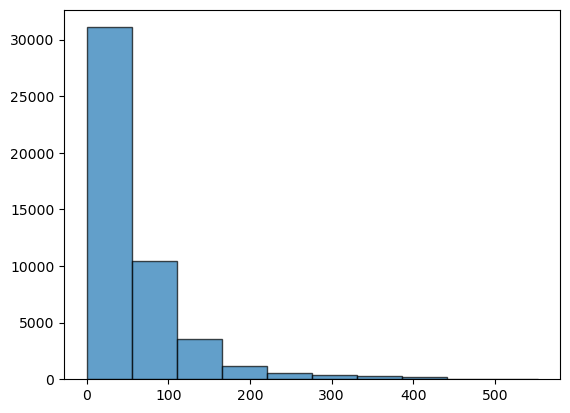

In [ ]:
# 카페 개수(500) 파생 변수 추가
cafe_gdf['카페 개수_500m'] = cafe_gdf.apply(count_mall_500m, axis=1, mall_gdf=cafe_gdf)

# 히스토그램으로 확인
plt.hist(cafe_gdf['카페 개수_500m'], bins=10, edgecolor='black', alpha=0.7)

### 2) 250m

(array([3.2176e+04, 9.5290e+03, 3.6890e+03, 1.1610e+03, 5.2400e+02,
        2.8000e+02, 1.7100e+02, 1.3600e+02, 7.4000e+01, 9.0000e+00]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <BarContainer object of 10 artists>)

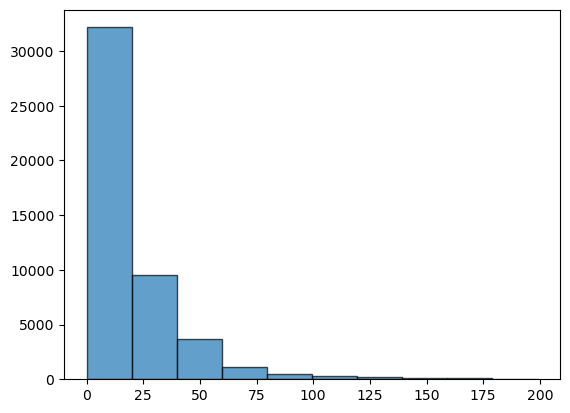

In [74]:
# 카페 개수(250) 파생 변수 추가
cafe_gdf['카페 개수_250m'] = cafe_gdf.apply(count_mall_250m, axis=1, mall_gdf=cafe_gdf)

# 히스토그램으로 확인
plt.hist(cafe_gdf['카페 개수_250m'], bins=10, edgecolor='black', alpha=0.7)

c:\Users\foma\miniconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\foma\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


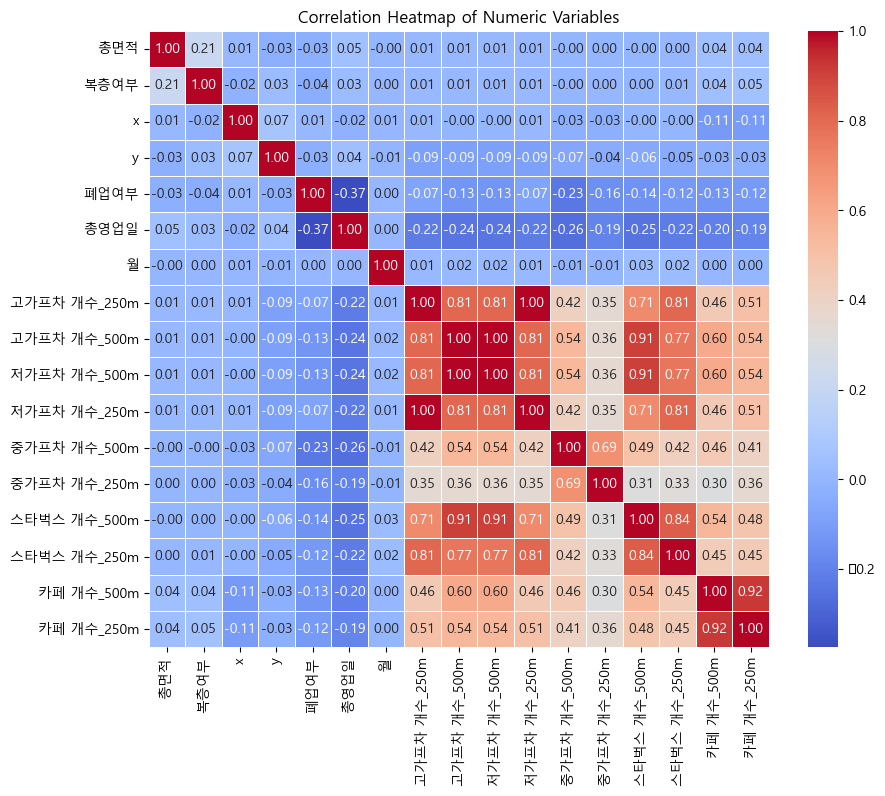

In [ ]:
# 수치형 변수만 추출하여 상관관계 계산
numeric_cafe_gdf = cafe_gdf.select_dtypes(include='number')
correlation_matrix = numeric_cafe_gdf.corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()

상관계수로 봤을 때 음의 상관계수가 더 높은 500m 반경으로 설정 

## 데이터셋 정리 - 반경 250m만 남기기

In [80]:
cafe_gdf.columns

Index(['업소명', '행정동명', '소재지도로명', '영업자시작일', '폐업일자', '총면적', '카페명', '복층여부', 'x',
       'y', '폐업여부', '카페유형', '총영업일', '월', '계절', 'xy_combined', 'geometry',
       '고가프차 개수_250m', '고가프차 개수_500m', '저가프차 개수_500m', '저가프차 개수_250m',
       '중가프차 개수_500m', '중가프차 개수_250m', '스타벅스 개수_500m', '스타벅스 개수_250m',
       '카페 개수_500m', '카페 개수_250m'],
      dtype='object')

In [82]:
cafe_gdf2 = cafe_gdf.drop(columns=['고가프차 개수_250m', '저가프차 개수_250m', '중가프차 개수_250m',  '스타벅스 개수_250m', '카페 개수_250m'])

In [56]:
cafe_gdf2.head()

,업소명,행정동명,소재지도로명,영업자시작일,폐업일자,총면적,카페명,복층여부,x,y,폐업여부,카페유형,총영업일,월,계절,xy_combined,geometry,고가프차 개수_500m,저가프차 개수_500m,중가프차 개수_500m,스타벅스 개수_500m,카페 개수_500m,음식점 개수_500m
0,커피앤모바일,장위제1동,서울특별시 성북구 장월로 174 (장위동),2010-01-04,2010-04-02,17.36,커피앤모바일,0,127.053810,37.619456,1,개인 카페,88,1,겨울,"(127.0538105, 37.6194558)",POINT (960624.088 1957872.788),0,0,0,0,0,286
1,커피사업지원센타,원효로제2동,"서울특별시 용산구 효창원로12길 37, (원효로4가,(지상1층))",2010-01-04,NaT,89.10,커피사업지원센타,0,126.952872,37.533354,0,개인 카페,5015,1,겨울,"(126.9528724, 37.533354)",POINT (951660.679 1948367.325),0,0,0,0,0,185
2,할리스커피(동덕여대점),월곡제1동,"서울특별시 성북구 화랑로11길 23-6, (하월곡동,지하1층~지상1층(지하30평,그...",2010-01-04,NaT,390.88,할리스,0,127.041656,37.603577,0,고가 프랜차이즈,5015,1,겨울,"(127.0416558, 37.6035772)",POINT (959542.837 1956116.294),0,0,0,0,0,670
3,카페모넬린,화양동,서울특별시 광진구 광나루로20길 36-3 (화양동),2010-01-04,2011-12-05,53.30,카페모넬린,0,127.073852,37.545336,1,개인 카페,700,1,겨울,"(127.0738519, 37.5453363)",POINT (962355.433 1949641.382),0,0,0,0,0,1508
4,(주)도르체비타,도곡2동,"서울특별시 강남구 언주로30길 56 (도곡동, 타워팰리스)",2010-01-05,2010-05-18,6.60,(주)도르체비타,0,127.054666,37.488555,1,개인 카페,133,1,겨울,"(127.0546662, 37.4885555)",POINT (960630.802 1943349.757),0,0,0,0,0,294


In [98]:
cafe_gdf2.to_csv("cafe_cafe_final.csv", index=False, encoding='utf-8-sig')

## 1-7. 음식점 개수

In [12]:
food = pd.read_csv("./파생변수데이터셋/food_.csv")

In [13]:
food.head()

,업소명,소재지도로명,소재지지번,영업자시작일,허가신고일,폐업일자,0,1
0,청수장A,"서울특별시 종로구 돈화문로5가길 1, 피카디리플러스 6층 6-30호 (돈의동)",서울특별시 종로구 돈의동 137번지 피카디리플러스,20190118,20190118,2020-02-25,126.991241,37.571035
1,아주로,"서울특별시 종로구 자하문로7길 68-2, 지하1층 (누하동)",서울특별시 종로구 누하동 1번지 11호,20190311,20190311,NaN,126.969142,37.580278
2,낙산길 20,"서울특별시 종로구 낙산길 20, 1층 (동숭동)",서울특별시 종로구 동숭동 129번지 144호,20190729,20190729,NaN,127.005581,37.580396
3,교동집,"서울특별시 종로구 사직로8길 4, 301동 B1층 113-5호 (사직동, 광화문 풍...",서울특별시 종로구 사직동 9번지 광화문 풍림스페이스본,20190920,20190920,NaN,126.968601,37.574404
4,동묘마케트,"서울특별시 종로구 종로54길 17-10, 지하1층 (창신동)",서울특별시 종로구 창신동 330번지 53호,20190523,20190523,NaN,127.014533,37.571795


In [14]:
food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328315 entries, 0 to 328314
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   업소명     328315 non-null  object 
 1   소재지도로명  328315 non-null  object 
 2   소재지지번   327855 non-null  object 
 3   영업자시작일  328315 non-null  int64  
 4   허가신고일   328315 non-null  int64  
 5   폐업일자    98307 non-null   object 
 6   0       328315 non-null  float64
 7   1       328315 non-null  float64
dtypes: float64(2), int64(2), object(4)
memory usage: 20.0+ MB


In [15]:
# 날짜타입으로 변환
food['영업자시작일'] = pd.to_datetime(food['영업자시작일'])
food['폐업일자'] = pd.to_datetime(food['폐업일자'])

In [16]:
food.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328315 entries, 0 to 328314
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   업소명     328315 non-null  object        
 1   소재지도로명  328315 non-null  object        
 2   소재지지번   327855 non-null  object        
 3   영업자시작일  328315 non-null  datetime64[ns]
 4   허가신고일   328315 non-null  int64         
 5   폐업일자    98307 non-null   datetime64[ns]
 6   0       328315 non-null  float64       
 7   1       328315 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 20.0+ MB


In [5]:
cafe_gdf2 = pd.read_csv('cafe_cafe_final.csv',  encoding='utf-8-sig')

In [25]:
cafe_gdf2.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 47749 entries, 0 to 47748
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   업소명           47749 non-null  object        
 1   행정동명          47749 non-null  object        
 2   소재지도로명        47749 non-null  object        
 3   영업자시작일        47749 non-null  datetime64[ns]
 4   폐업일자          19505 non-null  datetime64[ns]
 5   총면적           47749 non-null  float64       
 6   카페명           47749 non-null  object        
 7   복층여부          47749 non-null  int64         
 8   x             47749 non-null  float64       
 9   y             47749 non-null  float64       
 10  폐업여부          47749 non-null  int64         
 11  카페유형          47749 non-null  object        
 12  총영업일          47749 non-null  int64         
 13  월             47749 non-null  int64         
 14  계절            47749 non-null  object        
 15  xy_combined   47749 non-null

In [ ]:
# 전처리된 cafe 데이터셋 
## gpd로
cafe_gdf2 = gpd.GeoDataFrame(cafe_gdf2, geometry=gpd.points_from_xy(cafe_gdf2['x'], cafe_gdf2['y']), crs='EPSG:4326')
cafe_gdf2 = cafe_gdf2.to_crs(epsg=5179)

## 날짜타입으로 변환
cafe_gdf2['영업자시작일'] = pd.to_datetime(cafe_gdf2['영업자시작일'])
cafe_gdf2['폐업일자'] = pd.to_datetime(cafe_gdf2['폐업일자'])

In [ ]:
# 음식점 데이터셋 gpd로
food_gdf = gpd.GeoDataFrame(food, geometry=gpd.points_from_xy(food['0'], food['1']), crs='EPSG:4326') 
food_gdf =food_gdf.to_crs(epsg=5179)  

### 500m

(array([10809., 14678.,  8845.,  5599.,  3307.,  1958.,  1358.,   815.,
          342.,    38.]),
 array([   0. ,  453.3,  906.6, 1359.9, 1813.2, 2266.5, 2719.8, 3173.1,
        3626.4, 4079.7, 4533. ]),
 <BarContainer object of 10 artists>)

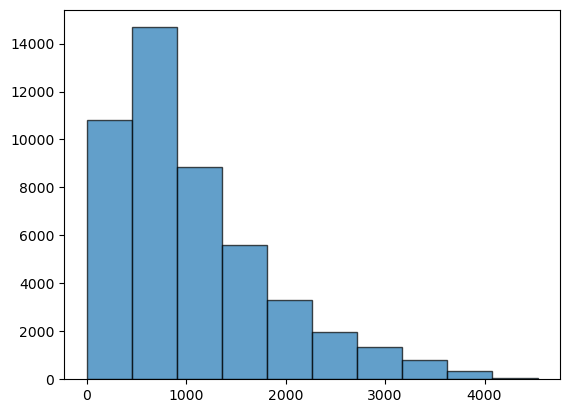

In [26]:
# 음식점 개수(500) 파생 변수 추가
cafe_gdf2['음식점 개수_500m'] = cafe_gdf2.apply(count_mall_500m, axis=1, mall_gdf=food_gdf)

# 히스토그램으로 확인
plt.hist(cafe_gdf2['음식점 개수_500m'], bins=10, edgecolor='black', alpha=0.7)

In [27]:
cafe_gdf2.to_csv("cafe_final_1102.csv", encoding='utf-8-sig')

# 2. 전처리 
- 총영업일 음수값있음 -> 다시 생성

In [28]:
df = cafe_gdf2.copy() 

(array([ 8103., 10952.,  6641.,  8381.,  5236.,  3292.,  2289.,  1344.,
          932.,   579.]),
 array([-365.,  173.,  711., 1249., 1787., 2325., 2863., 3401., 3939.,
        4477., 5015.]),
 <BarContainer object of 10 artists>)

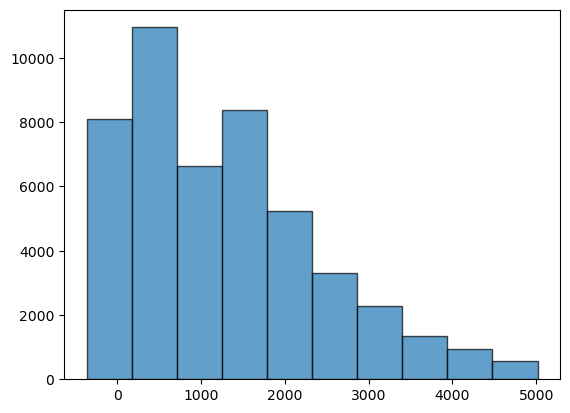

In [33]:
# 히스토그램으로 확인
plt.hist(df['총영업일'], bins=10, edgecolor='black', alpha=0.7)

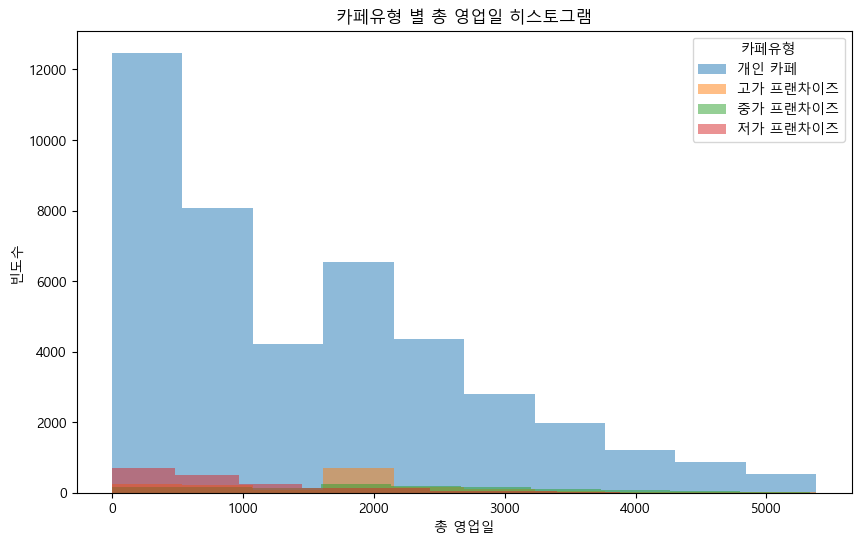

In [49]:
# Plotting histogram of '총 영업일' grouped by '카페유형'
plt.figure(figsize=(10, 6))
for cafe_type in df['카페유형'].unique():
    subset = df[df['카페유형'] == cafe_type]
    plt.hist(subset['총 영업일'], bins=10, alpha=0.5, label=cafe_type)

plt.xlabel('총 영업일')
plt.ylabel('빈도수')
plt.title('카페유형 별 총 영업일 히스토그램')
plt.legend(title='카페유형')
plt.show()

In [ ]:
df['총영업일']

0          88
1        5015
2        5015
3         700
4         133
         ... 
47744    -365
47745    -365
47746    -365
47747    -365
47748    -365
Name: 총영업일, Length: 47749, dtype: int64

In [39]:
# Converting dates from string to datetime format
df['영업자시작일'] = pd.to_datetime(df['영업자시작일'])
df['폐업일자'] = pd.to_datetime(df['폐업일자'], errors='coerce')

# Set a reference date for open stores (assuming today's date or a specified date like 2024-09-28)
reference_date = datetime(2024, 9, 28)

# Calculate '총 영업일' based on 폐업여부
df['총 영업일'] = df.apply(lambda row: (row['폐업일자'] - row['영업자시작일']).days if row['폐업여부'] == 1 
                           else (reference_date - row['영업자시작일']).days, axis=1)

In [41]:
df['총 영업일']

0          88
1        5381
2        5381
3         700
4         133
         ... 
47744       1
47745       1
47746       1
47747       1
47748       1
Name: 총 영업일, Length: 47749, dtype: int64

(array([13651.,  8939.,  4622.,  7672.,  4786.,  3097.,  2160.,  1311.,
          932.,   579.]),
 array([1.000e+00, 5.390e+02, 1.077e+03, 1.615e+03, 2.153e+03, 2.691e+03,
        3.229e+03, 3.767e+03, 4.305e+03, 4.843e+03, 5.381e+03]),
 <BarContainer object of 10 artists>)

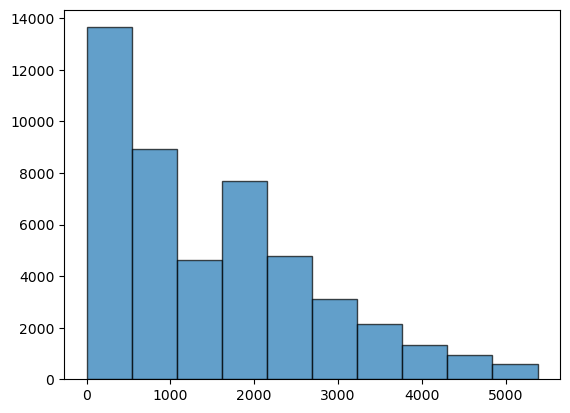

In [42]:
# 히스토그램으로 확인
plt.hist(df['총 영업일'], bins=10, edgecolor='black', alpha=0.7)

In [43]:
df = df.drop(columns=['총영업일'])

In [45]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 47749 entries, 0 to 47748
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   업소명           47749 non-null  object        
 1   행정동명          47749 non-null  object        
 2   소재지도로명        47749 non-null  object        
 3   영업자시작일        47749 non-null  datetime64[ns]
 4   폐업일자          19505 non-null  datetime64[ns]
 5   총면적           47749 non-null  float64       
 6   카페명           47749 non-null  object        
 7   복층여부          47749 non-null  int64         
 8   x             47749 non-null  float64       
 9   y             47749 non-null  float64       
 10  폐업여부          47749 non-null  int64         
 11  카페유형          47749 non-null  object        
 12  월             47749 non-null  int64         
 13  계절            47749 non-null  object        
 14  xy_combined   47749 non-null  object        
 15  geometry      47749 non-null

c:\Users\foma\miniconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
C:\Users\foma\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


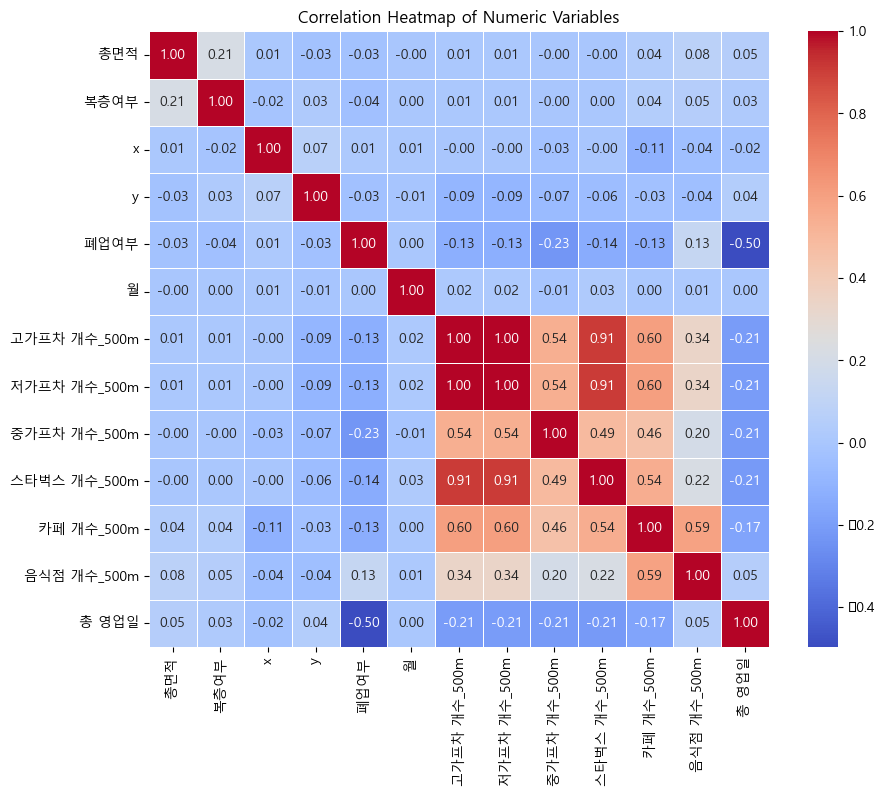

In [47]:
# 수치형 변수만 추출하여 상관관계 계산
numeric_df = df.select_dtypes(include='number')
correlation_matrix = numeric_df.corr()

# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()

In [58]:
df2 = df.copy()

In [83]:
df3 = df2.copy()

In [84]:
df3.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 47749 entries, 0 to 47748
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   업소명           47749 non-null  object        
 1   행정동명          47749 non-null  object        
 2   소재지도로명        47749 non-null  object        
 3   영업자시작일        47749 non-null  datetime64[ns]
 4   폐업일자          19505 non-null  datetime64[ns]
 5   총면적           47749 non-null  float64       
 6   카페명           47749 non-null  object        
 7   복층여부          47749 non-null  int64         
 8   x             47749 non-null  float64       
 9   y             47749 non-null  float64       
 10  폐업여부          47749 non-null  int64         
 11  카페유형          47749 non-null  object        
 12  월             47749 non-null  int64         
 13  계절            47749 non-null  object        
 14  xy_combined   47749 non-null  object        
 15  geometry      47749 non-null

In [86]:
df2.head()

,업소명,행정동명,소재지도로명,영업자시작일,폐업일자,총면적,카페명,복층여부,x,y,폐업여부,카페유형,월,계절,xy_combined,geometry,고가프차 개수_500m,저가프차 개수_500m,중가프차 개수_500m,스타벅스 개수_500m,카페 개수_500m,음식점 개수_500m,총 영업일,저가프차 개수_250m
0,커피앤모바일,장위제1동,서울특별시 성북구 장월로 174 (장위동),2010-01-04,2010-04-02,17.36,커피앤모바일,0,127.053810,37.619456,1,개인 카페,1,겨울,"(127.0538105, 37.6194558)",POINT (960624.088 1957872.788),0,0,0,0,0,286,88,0
1,커피사업지원센타,원효로제2동,"서울특별시 용산구 효창원로12길 37, (원효로4가,(지상1층))",2010-01-04,NaT,89.10,커피사업지원센타,0,126.952872,37.533354,0,개인 카페,1,겨울,"(126.9528724, 37.533354)",POINT (951660.679 1948367.325),0,0,0,0,0,185,5381,0
2,할리스커피(동덕여대점),월곡제1동,"서울특별시 성북구 화랑로11길 23-6, (하월곡동,지하1층~지상1층(지하30평,그...",2010-01-04,NaT,390.88,할리스,0,127.041656,37.603577,0,고가 프랜차이즈,1,겨울,"(127.0416558, 37.6035772)",POINT (959542.837 1956116.294),0,0,0,0,0,670,5381,0
3,카페모넬린,화양동,서울특별시 광진구 광나루로20길 36-3 (화양동),2010-01-04,2011-12-05,53.30,카페모넬린,0,127.073852,37.545336,1,개인 카페,1,겨울,"(127.0738519, 37.5453363)",POINT (962355.433 1949641.382),0,0,0,0,0,1508,700,0
4,(주)도르체비타,도곡2동,"서울특별시 강남구 언주로30길 56 (도곡동, 타워팰리스)",2010-01-05,2010-05-18,6.60,(주)도르체비타,0,127.054666,37.488555,1,개인 카페,1,겨울,"(127.0546662, 37.4885555)",POINT (960630.802 1943349.757),0,0,0,0,0,294,133,0


In [ ]:
df4 = df2.copy()

In [90]:
df4.to_csv("final_1102_1930.csv", index=False, encoding='utf-8-sig')

# 3. 경기지표 파생변수 만들기 
- 분기별 CSI(소비자 물가지수)
- 전 분기 대비 CSI(소비자 물가지수) 

In [ ]:
cpi_data = pd.read_csv("./소비자물가지수_2020100__20241103105732.csv", encoding = 'utf-8')

In [108]:
cpi_data_2 = cpi_data.T

In [109]:
cpi_data_2.to_csv("cpi.csv",index = "False", encoding = 'utf-8')

In [116]:
cpi = pd.read_csv("./cpi.csv", encoding = 'cp949')

In [118]:
cpi

,분기,분기별CPI
0,2010.1/4,85.523
1,2010.2/4,86.070
2,2010.3/4,86.733
3,2010.4/4,87.165
4,2011.1/4,88.806
5,2011.2/4,89.497
6,2011.3/4,90.476
7,2011.4/4,90.620
8,2012.1/4,91.481
9,2012.2/4,91.671


In [121]:
# '분기' 문자열을 'YYYY-Q#' 형식으로 변환
cpi['Quarter'] = cpi['분기'].str.replace(r'\.(\d)/4', r'-Q\1', regex=True)

# 분기를 datetime 형식으로 변환 (분기 시작일로 변환: 1월, 4월, 7월, 10월)
cpi['Quarter'] = pd.to_datetime(
    cpi['Quarter'].str.replace('-Q1', '-01')
                  .str.replace('-Q2', '-04')
                  .str.replace('-Q3', '-07')
                  .str.replace('-Q4', '-10')
)

In [122]:
cpi

,분기,분기별CPI,Quarter
0,2010.1/4,85.523,2010-01-01
1,2010.2/4,86.070,2010-04-01
2,2010.3/4,86.733,2010-07-01
3,2010.4/4,87.165,2010-10-01
4,2011.1/4,88.806,2011-01-01
5,2011.2/4,89.497,2011-04-01
6,2011.3/4,90.476,2011-07-01
7,2011.4/4,90.620,2011-10-01
8,2012.1/4,91.481,2012-01-01
9,2012.2/4,91.671,2012-04-01


In [124]:
cpi.to_csv("cpi_2.csv",index = "False")

In [127]:
cpi.head()

,분기,분기별CPI,Quarter
0,2010.1/4,85.523,2010-01-01
1,2010.2/4,86.070,2010-04-01
2,2010.3/4,86.733,2010-07-01
3,2010.4/4,87.165,2010-10-01
4,2011.1/4,88.806,2011-01-01


In [129]:
cpi['Quarter'] = pd.to_datetime(cpi['Quarter'])

Matplotlib is building the font cache; this may take a moment.


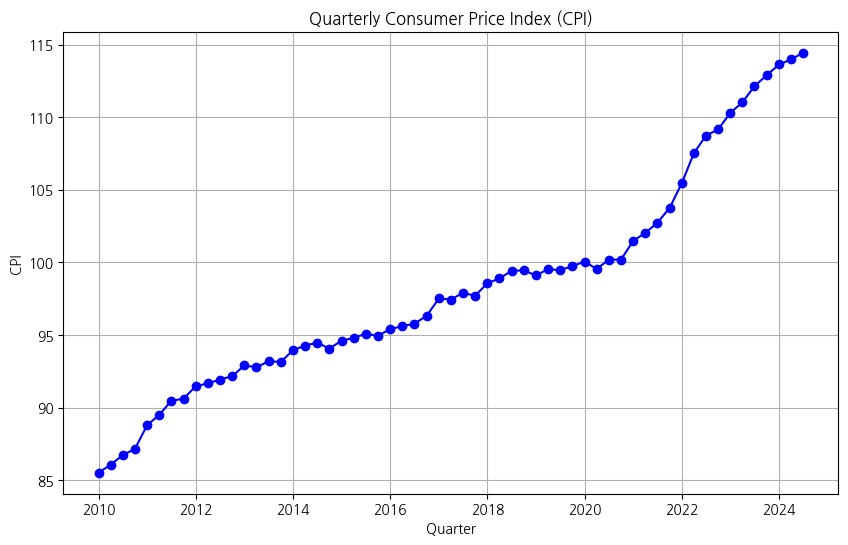

In [130]:
# 분기별 CPI 시각화
plt.figure(figsize=(10, 6))
plt.plot(cpi['Quarter'], cpi['분기별CPI'], marker='o', color='b')
plt.title('Quarterly Consumer Price Index (CPI)')
plt.xlabel('Quarter')
plt.ylabel('CPI')
plt.grid(True)
plt.show()

## csi

In [135]:
pip install openpyxl

^C
Note: you may need to restart the kernel to use updated packages.


In [136]:
csi_data = pd.read_excel("./CSI.xlsx")

In [137]:
csi_data

,Unnamed: 0,201001월,201002월,201003월,201004월,201005월,201006월,201007월,201008월,201009월,201010월,201011월,201012월,201101월,201102월,201103월,201104월,201105월,201106월,201107월,201108월,201109월,201110월,201111월,201112월,201201월,201202월,201203월,201204월,201205월,201206월,201207월,201208월,201209월,201210월,201211월,201212월,201301월,201302월,201303월,201304월,201305월,201306월,201307월,201308월,201309월,201310월,201311월,201312월,201401월,201402월,201403월,201404월,201405월,201406월,201407월,201408월,201409월,201410월,201411월,201412월,201501월,201502월,201503월,201504월,201505월,201506월,201507월,201508월,201509월,201510월,201511월,201512월,201601월,201602월,201603월,201604월,201605월,201606월,201607월,201608월,201609월,201610월,201611월,201612월,201701월,201702월,201703월,201704월,201705월,201706월,201707월,201708월,201709월,201710월,201711월,201712월,201801월,201802월,201803월,201804월,201805월,201806월,201807월,201808월,201809월,201810월,201811월,201812월,201901월,201902월,201903월,201904월,201905월,201906월,201907월,201908월,201909월,201910월,201911월,201912월,202001월,202002월,202003월,202004월,202005월,202006월,202007월,202008월,202009월,202010월,202011월,202012월,202101월,202102월,202103월,202104월,202105월,202106월,202107월,202108월,202109월,202110월,202111월,202112월,202201월,202202월,202203월,202204월,202205월,202206월,202207월,202208월,202209월,202210월,202211월,202212월,202301월,202302월,202303월,202304월,202305월,202306월,202307월,202308월,202309월,202310월,202311월,202312월,202401월,202402월,202403월,202404월,202405월,202406월,202407월,202408월,202409월,202410월
0,소비자심리지수,116.9,114.4,114.3,113.9,114.0,115.8,115.7,113.3,112.3,111.8,115.1,113.9,112.4,110.1,98.9,101.1,104.8,102.4,102.8,98.1,97.4,100.0,104.6,98.5,97.2,101.5,102.1,106.4,106.8,100.8,99.4,99.8,97.8,99.1,99.3,98.2,101.8,101.1,104.2,101.6,104.1,105.0,104.7,104.9,101.4,106.5,108.1,107.4,110.0,109.0,109.5,109.5,105.2,108.0,105.5,107.4,108.3,105.5,103.3,101.7,103.1,103.8,102.0,104.8,106.2,98.8,100.8,102.2,103.4,105.9,106.6,103.3,100.5,98.3,100.6,102.2,99.8,99.3,101.6,102.5,102.4,102.7,96.0,94.3,93.3,94.5,97.0,101.8,109.0,112.3,112.5,111.1,108.8,110.3,113.6,112.1,111.3,109.6,109.5,108.5,109.4,106.8,102.1,100.1,101.0,100.2,96.6,97.8,98.5,100.6,100.8,102.7,98.9,98.6,97.0,93.5,98.0,99.7,102.0,101.5,105.3,98.0,79.7,72.1,78.8,83.1,85.4,89.3,80.7,92.7,99.1,91.0,95.3,97.4,100.6,102.4,105.5,110.8,103.6,102.8,104.1,107.3,108.2,104.3,104.9,103.5,103.7,104.3,103.1,96.8,86.2,89.0,91.6,89.0,86.6,90.1,90.7,90.2,92.0,95.2,98.1,100.8,103.4,103.3,99.8,98.2,97.3,99.7,101.6,101.9,100.7,100.7,98.4,100.9,103.6,100.8,100.0,101.7


In [138]:
csi = csi_data.T

In [139]:
csi

,0
Unnamed: 0,소비자심리지수
201001월,116.9
201002월,114.4
201003월,114.3
201004월,113.9
...,...
202406월,100.9
202407월,103.6
202408월,100.8
202409월,100.0


In [140]:
csi.to_csv("csi.csv")

In [142]:
csi = pd.read_csv("csi.csv",encoding = 'cp949')

In [143]:
csi

,년도월,소비자심리지수
0,201001월,116.9
1,201002월,114.4
2,201003월,114.3
3,201004월,113.9
4,201005월,114.0
...,...,...
173,202406월,100.9
174,202407월,103.6
175,202408월,100.8
176,202409월,100.0


In [147]:
df = csi.copy()

In [148]:
# '년도월' 열에서 '월' 제거하고 '년도-월' 형식으로 변환하여 datetime 형식으로 변환
df['년도월'] = pd.to_datetime(df['년도월'].str.replace('월', ''), format='%Y%m')

In [149]:
df

,년도월,소비자심리지수
0,2010-01-01,116.9
1,2010-02-01,114.4
2,2010-03-01,114.3
3,2010-04-01,113.9
4,2010-05-01,114.0
...,...,...
173,2024-06-01,100.9
174,2024-07-01,103.6
175,2024-08-01,100.8
176,2024-09-01,100.0


In [152]:
df.to_csv('df.csv',index = False)

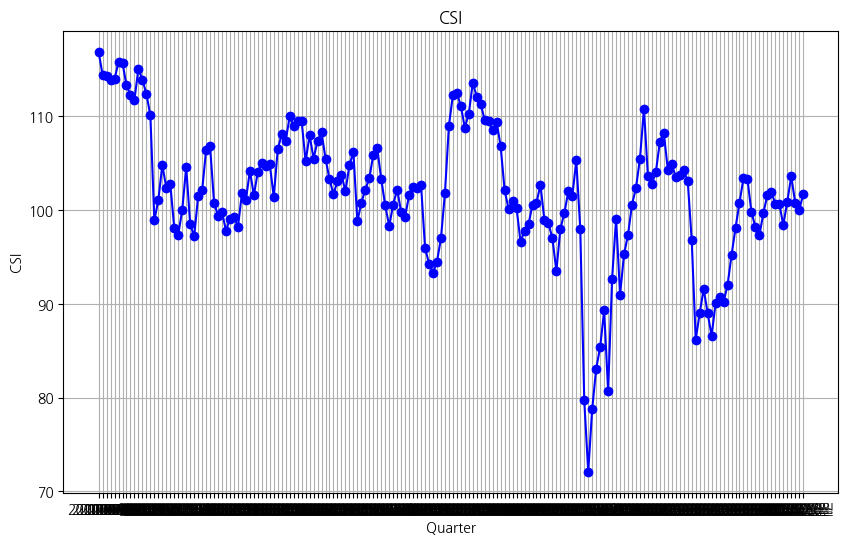

In [151]:
# 분기별 CSI 시각화
plt.figure(figsize=(10, 6))
plt.plot(csi['년도월'], csi['소비자심리지수'], marker='o', color='b')
plt.title('CSI')
plt.xlabel('Quarter')
plt.ylabel('CSI')
plt.grid(True)
plt.show()

In [153]:
# Convert the '년도월' column to datetime format
df['년도월'] = pd.to_datetime(df['년도월'])

# Set '년도월' as the index for easier resampling
df.set_index('년도월', inplace=True)

# Resample the data by quarter and calculate the mean for '소비자심리지수'
quarterly_avg_df = df.resample('Q').mean().rename(columns={'소비자심리지수': '분기별 평균 소비자심리지수'})

C:\Users\foma\AppData\Local\Temp\ipykernel_14160\1565502013.py:8: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarterly_avg_df = df.resample('Q').mean().rename(columns={'소비자심리지수': '분기별 평균 소비자심리지수'})


In [154]:
# Resample the data by quarter and calculate the mean for '소비자심리지수'
quarterly_avg_df

,분기별 평균 소비자심리지수
년도월,
2010-03-31,115.200000
2010-06-30,114.566667
2010-09-30,113.766667
2010-12-31,113.600000
2011-03-31,107.133333
2011-06-30,102.766667
2011-09-30,99.433333
2011-12-31,101.033333
2012-03-31,100.266667


In [155]:
quarterly_avg_df = quarterly_avg_df.round(2)

In [156]:
quarterly_avg_df

,분기별 평균 소비자심리지수
년도월,
2010-03-31,115.20
2010-06-30,114.57
2010-09-30,113.77
2010-12-31,113.60
2011-03-31,107.13
2011-06-30,102.77
2011-09-30,99.43
2011-12-31,101.03
2012-03-31,100.27


In [157]:
quarterly_avg_df['분기'] = quarterly_avg_df.index.to_series().apply(
    lambda x: f"{x.year}-{(x.month // 3)}분기" if x.month in [3, 6, 9, 12] else None
)

In [158]:
quarterly_avg_df

,분기별 평균 소비자심리지수,분기
년도월,,
2010-03-31,115.20,2010-1분기
2010-06-30,114.57,2010-2분기
2010-09-30,113.77,2010-3분기
2010-12-31,113.60,2010-4분기
2011-03-31,107.13,2011-1분기
2011-06-30,102.77,2011-2분기
2011-09-30,99.43,2011-3분기
2011-12-31,101.03,2011-4분기
2012-03-31,100.27,2012-1분기


In [159]:
quarterly_avg_df.to_csv("csiiiiiiii.csv",index = False)

In [162]:
final_df = df4.copy()

In [163]:
# Creating a new column '폐업분기' in the format '년도-분기' based on '폐업일자'

# Ensure '폐업일자' is in datetime format
final_df['폐업일자'] = pd.to_datetime(final_df['폐업일자'], errors='coerce')

# Define a function to generate the quarter string in '년도-분기' format
def get_closure_quarter(date):
    if pd.notnull(date):
        quarter = (date.month - 1) // 3 + 1  # Determine quarter from month
        return f"{date.year}-{quarter}분기"
    return None

# Apply the function to '폐업일자' to create '폐업분기'
final_df['폐업분기'] = final_df['폐업일자'].apply(get_closure_quarter)


In [165]:
final_df.to_csv("ffff.csv",index = False)

In [166]:
ffff_df = final_df.copy()
csiiiiiiii_df = quarterly_avg_df.copy()

In [167]:
# Merge 'ffff_df' with 'csiiiiiiii_df' based on matching '폐업분기' in ffff_df with '분기' in csiiiiiiii_df
# and assign '분기별 평균 소비자심리지수' value to a new column '소비자물가지수' in ffff_df.

# Performing the merge to add the new column based on the matching '폐업분기' and '분기' values
merged_df = ffff_df.merge(csiiiiiiii_df, left_on='폐업분기', right_on='분기', how='left')

# Renaming the added column to '소비자물가지수'
merged_df.rename(columns={'분기별 평균 소비자심리지수': '소비자물가지수'}, inplace=True)

In [173]:
csi_data = merged_df[['폐업일자','소비자물가지수','분기']]

In [174]:
csi_data.to_csv("csi_data.csv",index=False)

In [169]:
close_quarter = merged_df['분기']

In [175]:
csi_data

,폐업일자,소비자물가지수,분기
0,2010-04-02,114.57,2010-2분기
1,NaT,NaN,NaN
2,NaT,NaN,NaN
3,2011-12-05,101.03,2011-4분기
4,2010-05-18,114.57,2010-2분기
...,...,...,...
47744,NaT,NaN,NaN
47745,NaT,NaN,NaN
47746,NaT,NaN,NaN
47747,NaT,NaN,NaN


## quarterly_avg_df   EDA

In [177]:
quarterly_avg_df.head()

,분기별 평균 소비자심리지수,분기
년도월,,
2010-03-31,115.20,2010-1분기
2010-06-30,114.57,2010-2분기
2010-09-30,113.77,2010-3분기
2010-12-31,113.60,2010-4분기
2011-03-31,107.13,2011-1분기


In [191]:
# Adding the '전분기 대비 추이' column
quarterly_avg_df['전분기 대비 추이'] = quarterly_avg_df['분기별 평균 소비자심리지수'].diff()

In [ ]:
quarterly_avg_df

,분기별 평균 소비자심리지수,분기,Year,Quarter,Month,Date,전분기 대비 추이
년도월,,,,,,,
2010-03-31,115.20,2010-1분기,2010,1,03,2010-03-01,NaN
2010-06-30,114.57,2010-2분기,2010,2,06,2010-06-01,-0.63
2010-09-30,113.77,2010-3분기,2010,3,09,2010-09-01,-0.80
2010-12-31,113.60,2010-4분기,2010,4,12,2010-12-01,-0.17
2011-03-31,107.13,2011-1분기,2011,1,03,2011-03-01,-6.47
2011-06-30,102.77,2011-2분기,2011,2,06,2011-06-01,-4.36
2011-09-30,99.43,2011-3분기,2011,3,09,2011-09-01,-3.34
2011-12-31,101.03,2011-4분기,2011,4,12,2011-12-01,1.60
2012-03-31,100.27,2012-1분기,2012,1,03,2012-03-01,-0.76


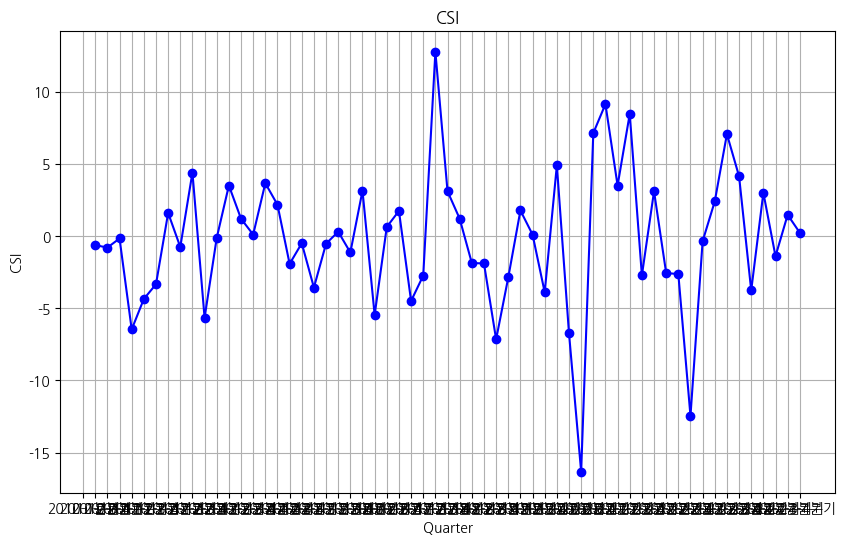

In [193]:
# 분기별 CSI 시각화
plt.figure(figsize=(10, 6))
plt.plot(quarterly_avg_df['분기'], quarterly_avg_df['전분기 대비 추이'], marker='o', color='b')
plt.title('CSI')
plt.xlabel('Quarter')
plt.ylabel('CSI')
plt.grid(True)
plt.show()

In [196]:
df_csi_change = quarterly_avg_df[['분기','전분기 대비 추이']]

In [198]:
df_csi_change.rename(columns = {'전분기 대비 추이' : 'CSI_전분기 대비 변동'},inplace = True)

C:\Users\foma\AppData\Local\Temp\ipykernel_14160\1813762104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_csi_change.rename(columns = {'전분기 대비 추이' : 'CSI_전분기 대비 변동'},inplace = True)


In [199]:
df_csi_change

,분기,CSI_전분기 대비 변동
년도월,,
2010-03-31,2010-1분기,NaN
2010-06-30,2010-2분기,-0.63
2010-09-30,2010-3분기,-0.80
2010-12-31,2010-4분기,-0.17
2011-03-31,2011-1분기,-6.47
2011-06-30,2011-2분기,-4.36
2011-09-30,2011-3분기,-3.34
2011-12-31,2011-4분기,1.60
2012-03-31,2012-1분기,-0.76


In [ ]:
# 데이터에 합치기 - 같은 분기에 넣어어

In [200]:
d = pd.read_csv("./아마도 이게 진짜 최종 데이터셋.csv")

In [ ]:
# Ensure '폐업일자' is in datetime format
d['폐업일자'] = pd.to_datetime(d['폐업일자'], errors='coerce')

# Define a function to generate the quarter string in '년도-분기' format
def get_closure_quarter(date):
    if pd.notnull(date):
        quarter = (date.month - 1) // 3 + 1  # Determine quarter from month
        return f"{date.year}-{quarter}분기"
    return None

# Apply the function to '폐업일자' to create '폐업분기'
d['폐업분기'] = d['폐업일자'].apply(get_closure_quarter)

In [204]:
merged_df2 = d.merge(df_csi_change, left_on='폐업분기', right_on='분기', how='left')

In [207]:
real_final = merged_df2.drop(columns='분기_y')

In [208]:
real_final

,업소명,행정동명,소재지도로명,영업자시작일,폐업일자,총면적,카페명,복층여부,x,y,폐업여부,카페유형,월,계절,xy_combined,geometry,고가프차 개수_500m,저가프차 개수_500m,중가프차 개수_500m,스타벅스 개수_500m,카페 개수_500m,음식점 개수_500m,총 영업일,소비자물가지수,분기_x,bank_500m 개수,elementary_500m 개수,middle_500m 개수,high_800m 개수,hospital_re_500m 개수,univ_1000m 개수,bus_250m 개수,subway_250m 존재여부,hospital_big_1000m 개수,행정동코드,1분기 평균,2분기 평균,3분기 평균,4분기 평균,월 임대료 평균 점수,환산 임대료 평균 점수,폐업분기,CSI_전분기 대비 변동
0,커피앤모바일,장위제1동,서울특별시 성북구 장월로 174 (장위동),2010-01-04,2010-04-02,17.36,커피앤모바일,0,127.053810,37.619456,1,개인 카페,1,겨울,"(127.0538105, 37.6194558)",POINT (960624.0880540323 1957872.7877259788),0,0,0,0,0,286,88,114.57,2010-2분기,1,2,2,1,0,2,20,0,0,11290760.0,-0.204450,-0.204372,-0.228888,-0.228432,-1.448152,-1.338849,2010-2분기,-0.63
1,커피사업지원센타,원효로제2동,"서울특별시 용산구 효창원로12길 37, (원효로4가,(지상1층))",2010-01-04,NaT,89.10,커피사업지원센타,0,126.952872,37.533354,0,개인 카페,1,겨울,"(126.9528724, 37.533354)",POINT (951660.6788685165 1948367.32456717),0,0,0,0,0,185,5381,NaN,NaN,1,1,1,1,0,0,10,0,0,11170570.0,-0.152826,-0.212961,-0.204699,-0.129180,-0.076715,-0.227809,None,NaN
2,할리스커피(동덕여대점),월곡제1동,"서울특별시 성북구 화랑로11길 23-6, (하월곡동,지하1층~지상1층(지하30평,그...",2010-01-04,NaT,390.88,할리스,0,127.041656,37.603577,0,고가 프랜차이즈,1,겨울,"(127.0416558, 37.6035772)",POINT (959542.8374800174 1956116.2944994038),0,0,0,0,0,670,5381,NaN,NaN,4,0,0,0,0,1,10,1,0,11290715.0,-0.224640,-0.184070,-0.189734,-0.189858,-0.637874,-0.736274,None,NaN
3,카페모넬린,화양동,서울특별시 광진구 광나루로20길 36-3 (화양동),2010-01-04,2011-12-05,53.30,카페모넬린,0,127.073852,37.545336,1,개인 카페,1,겨울,"(127.0738519, 37.5453363)",POINT (962355.433017725 1949641.3819428585),0,0,0,0,0,1508,700,101.03,2011-4분기,1,0,0,1,0,1,4,0,1,11215710.0,0.597247,0.491381,0.460425,0.577810,0.532188,0.451431,2011-4분기,1.60
4,(주)도르체비타,도곡2동,"서울특별시 강남구 언주로30길 56 (도곡동, 타워팰리스)",2010-01-05,2010-05-18,6.60,(주)도르체비타,0,127.054666,37.488555,1,개인 카페,1,겨울,"(127.0546662, 37.4885555)",POINT (960630.8017996107 1943349.7569302018),0,0,0,0,0,294,133,114.57,2010-2분기,11,1,3,5,0,0,6,0,1,11680656.0,-0.215965,-0.171279,-0.158098,-0.171545,0.164649,0.195094,2010-2분기,-0.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47744,피치키치 케이크 홍대,연남동,"서울특별시 마포구 성미산로 105, 1층 일부호 (연남동)",2024-09-27,NaT,72.00,피치키치 케이크 홍대,0,126.918739,37.561967,0,개인 카페,9,가을,"(126.9187391, 37.5619666)",POINT (948664.5650330518 1951559.8422993172),2,4,2,0,183,784,1,NaN,NaN,1,0,1,3,0,0,4,0,0,11440710.0,-0.177772,-0.209793,-0.194441,-0.184971,0.976666,0.854448,None,NaN
47745,일리터리,화곡제1동,"서울특별시 강서구 강서로17다길 5-23, 1층 (화곡동)",2024-09-27,NaT,43.20,일리터리,0,126.840864,37.532782,0,개인 카페,9,가을,"(126.8408636, 37.5327818)",POINT (941764.0300957579 1948367.3091986764),1,4,2,1,65,577,1,NaN,NaN,2,1,1,0,2,0,3,0,0,11500540.0,-0.267316,-0.282445,-0.253341,-0.287214,-1.201071,-1.002128,None,NaN
47746,보난자커피 미아점,길음제1동,"서울특별시 성북구 동소문로 315, 현대백화점미아점 지상4층 (길음동)",2024-09-27,NaT,87.93,보난자커피 미아점,0,127.028747,37.608408,0,개인 카페,9,가을,"(127.0287466, 37.6084082)",POINT (958406.0508219984 1956657.9133306672),5,5,3,4,75,588,1,NaN,NaN,1,1,1,3,4,0,9,0,1,11290660.0,-0.271031,-0.271150,-0.249136,-0.265593,0.466966,0.447756,None,NaN
47747,메가엠지씨커피 신정교사거리점,신정2동,"서울특별시 양천구 신목로 36, 대보빌딩 1층 101호 (신정동)",2024-09-27,NaT,58.50,메가커피,0,126.873787,37.518854,0,저가 프랜차이즈,9,가을,"(126.8737871, 37.5188543)",POINT (944662.6284049437 1946802.2462005657),2,3,1,1,51,267,1,NaN,NaN,1,2,1,1,0,0,7,0,0,11470630.0,-0.532241,-0.474827,-0.470145,-0.490720,-0.886023,-0.698797,None,NaN


In [209]:
real_final.to_csv('real_final.csv',index=False)

In [215]:
modeling_data = real_final.drop(columns = ['xy_combined',	'geometry','분기_x','행정동코드' ,'카페명','x','y'] ) 

In [217]:
modeling_data.to_csv('modeling_data.csv',index=False)

In [218]:
modeling_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47749 entries, 0 to 47748
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   업소명                    47749 non-null  object        
 1   행정동명                   47749 non-null  object        
 2   소재지도로명                 47749 non-null  object        
 3   영업자시작일                 47749 non-null  object        
 4   폐업일자                   19505 non-null  datetime64[ns]
 5   총면적                    47749 non-null  float64       
 6   복층여부                   47749 non-null  int64         
 7   폐업여부                   47749 non-null  int64         
 8   카페유형                   47749 non-null  object        
 9   월                      47749 non-null  int64         
 10  계절                     47749 non-null  object        
 11  고가프차 개수_500m           47749 non-null  int64         
 12  저가프차 개수_500m           47749 non-null  int64         
 13  중

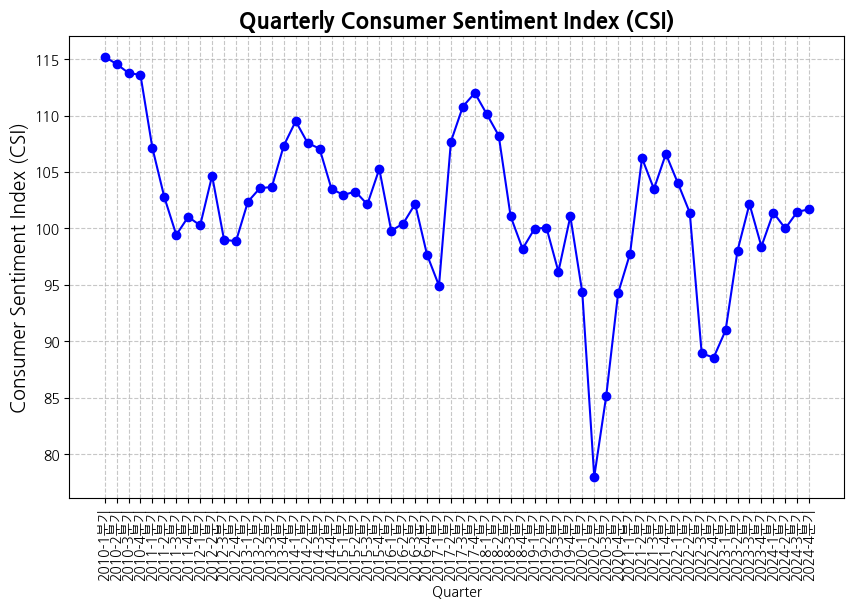

In [186]:
plt.figure(figsize=(10, 6))
plt.title('Quarterly Consumer Sentiment Index (CSI)', fontsize=16, fontweight='bold')
plt.xlabel('Quarter', fontsize=10)
plt.ylabel('Consumer Sentiment Index (CSI)', fontsize=14)
plt.xticks(rotation=90)  # Rotating x-ticks for better readability
plt.grid(True, linestyle='--', alpha=0.7)
plt.plot(quarterly_avg_df['분기'], quarterly_avg_df['분기별 평균 소비자심리지수'], marker='o', color='b')

In [ ]:
quarterly_avg_df

In [ ]:
plt.figure(figsize=(14, 6))

# 첫 번째 y축: Monthly Closure Counts
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(df_concat['분기'], df_concat['CSI_분기'], marker='o', color='b', label='Monthly Closure Count')
ax1.set_xlabel('Date')
ax1.set_ylabel('분기별 CSI지수', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# 두 번째 y축: Quarterly Closure Counts
ax2 = ax1.twinx()  # 두 번째 y축 생성
ax2.plot(df_concat['분기'], df_concat['분기 당 카페 폐점수'], marker='o', color='g', label='Quarterly Closure Count')
ax2.set_ylabel('분기별 폐점수', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# x축 레이블 회전 설정
ax1.tick_params(axis='x', rotation=90)

# x축 간격 설정: 인덱스를 3칸 간격으로 표시
ax1.set_xticks(df_concat['분기'][::4])

ax1.grid(True)

# 제목과 레전드 설정
plt.title('분기별 CSI지수와 카페 폐점수') 
fig.tight_layout()  # 레이아웃 조정
plt.show()